# Layer Collapse experiment

### add the parent directory to path

### **Import modules**

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import matplotlib
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

# import os
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar
from models.Fed import FedAvg
from models.test import test_img
from models import imagenet_vgg

/Users/adamborgula/dev/bachelor_thesis/federated-learning


### **Set Default Args** 

In [9]:
class Args():
    # federated arguments
    epochs = 1
    num_users = 1
    frac = 1
    local_ep = 5
    local_bs = 10
    bs = 16
    lr = 0.01
    momentum = 0.5
    split = 'user'

    # model arguments
    model = 'mlp'
    kernel_num = 9
    kernel_sizes = [3,4]
    norm = 'batch_norm'
    num_filters = 32
    max_pool = True

    # other arguments
    dataset = 'mnist'
    iid = True # action: store_true
    num_classes = 10
    num_channels = 3
    gpu = 0
    stopping_rounds = 10
    verbose = False # action: store_true
    seed = 1
    all_clients = False # action: store_true
    compression = 0.0
    prune_epochs = 100
    pruner = 'mag'
    iters = 15

    # test customization
    save = False
    show = True

### **The Experiment Without Bias** 
- bias was causing weird pruning behaviour

In [ ]:
def run_experiment_no_bias():
    args=Args()
    args.local_ep = 5
    args.dataset = 'mnist'
    args.iters = 10
    x_vals, y_vals = [],[]

    args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

    alphas = [i/5 for i in range(10, args.iters)]
    seeds = [0]
    x_vals = [10**alpha for alpha in alphas]
    y_vals = {'mag': [], 'synflow': []}

    for c in x_vals:
        for seed in seeds:
            np.random.seed(args.seed)
            torch.manual_seed(args.seed)
            torch.cuda.manual_seed(args.seed)
            torch.backends.cudnn.deterministic = True
            for pruner in ('synflow', 'mag'):
                args.pruner = pruner
                args.compression = c

                # load dataset and split users
                if args.dataset == 'mnist':
                    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
                    dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
                    dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
                    # sample users
                    if args.iid:
                        dict_users = mnist_iid(dataset_train, args.num_users)
                    else:
                        dict_users = mnist_noniid(dataset_train, args.num_users)
                elif args.dataset == 'cifar':
                    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                    dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
                    dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
                    if args.iid:
                        dict_users = cifar_iid(dataset_train, args.num_users)
                    else:
                        exit('Error: only consider IID setting in CIFAR10')
                else:
                    exit('Error: unrecognized dataset')
                img_size = dataset_train[0][0].shape

                # build model
                if args.model == 'cnn' and args.dataset == 'cifar':
                    net_glob = CNNCifar(args=args).to(args.device)
                    #model = models.vgg16(weights = None)

                    # Step 4: Modify last layer
                    #num_classes = 10  # CIFAR-10 has 10 classes
                    #model.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)
                    #net_glob = model.to(args.device)
                elif args.model == 'cnn' and args.dataset == 'mnist':
                    net_glob = CNNMnist(args=args).to(args.device)
                elif args.model == 'mlp':
                    len_in = 1
                    for x in img_size:
                        len_in *= x
                    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
                else:
                    exit('Error: unrecognized model')
                print(net_glob)
                net_glob.train()

                # copy weights
                w_glob = net_glob.state_dict()

                # training
                loss_train = []
                cv_loss, cv_acc = [], []
                val_loss_pre, counter = 0, 0
                net_best = None
                best_loss = None
                val_acc_list, net_list = [], []

                if args.all_clients: 
                    print("Aggregation over all clients")
                    w_locals = [w_glob for i in range(args.num_users)]
                for iter in range(args.epochs):
                    loss_locals = []
                    if not args.all_clients:
                        w_locals = []
                    m = max(int(args.frac * args.num_users), 1)
                    idxs_users = [0]
                    for idx in idxs_users:
                        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                        if args.all_clients:
                            w_locals[idx] = copy.deepcopy(w)
                        else:
                            w_locals.append(copy.deepcopy(w))
                        loss_locals.append(copy.deepcopy(loss))
                    # update global weights
                    w_glob = FedAvg(w_locals)

                    # copy weight to net_glob
                    net_glob.load_state_dict(w_glob)

                    # print loss
                    loss_avg = sum(loss_locals) / len(loss_locals)
                    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
                    loss_train.append(loss_avg)

                # plot loss curve
                # plt.figure()
                # plt.plot(range(len(loss_train)), loss_train)
                # plt.ylabel('train_loss')
                #   plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

                # testing
                net_glob.eval()
                acc_train, loss_train = test_img(net_glob, dataset_train, args)
                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                print("Training accuracy: {:.2f}".format(acc_train))
                print("Testing accuracy: {:.2f}".format(acc_test))

                y_vals[args.pruner].append(acc_test)
                #y_vals[args.pruner].append(0)

    print('synflow test accuracy: ', y_vals['synflow'])
    print('mag test accuracy: ', y_vals['mag'])
    # Plot both charts on the same axis
    plt.figure()
    plt.xscale('log')
    plt.plot(x_vals, y_vals['synflow'], label='Synflow', linestyle='-', marker='o', color='r')
    plt.plot(x_vals, y_vals['mag'], label='Mag', linestyle='-', marker='o', color='b')

    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Synflow vs Mag')

    # Add legend
    plt.legend()

   # Show plot
    if args.show:
        plt.show()

    # Save plot
    if args.save:
        plt.savefig('../save/synflow_test_{}_{}_{}.png'.format(args.prune_epochs, args.dataset, args.model))

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=False)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=False)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=50, bias=False)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=100, bias=False)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=200, bias=False)
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=200, out_features=10, bias=False)
  )
)
synflow
100.0
4306.0 430600 426294.0
tensor([[False, False, False, False, False, False, False, False, False, False]])
Round   0, Average loss 1.145
Training accuracy: 90.46
Testing accuracy: 90.28
MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=False)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=False)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=50, bias=False)
    (5): ReLU()
    (6)

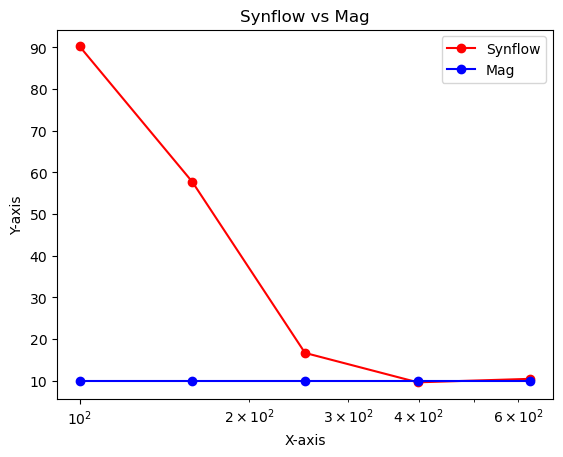

In [12]:
run_experiment_no_bias()

### **The Original Experiment**

In [6]:
def run_experiment():
    args=Args()
    x_vals, y_vals = [],[]

    args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

    # matplotlib.use('qtagg')

    compression = 1
    alphas = [i/4 for i in range(args.iters)]
    # seeds = [0,99,345]
    seeds = [0]
    x_vals = [10**alpha for alpha in alphas]
    y_vals = {'mag': [], 'synflow': []}

    for i in range(args.iters):
        for seed in seeds:
            np.random.seed(args.seed)
            torch.manual_seed(args.seed)
            torch.cuda.manual_seed(args.seed)
            torch.backends.cudnn.deterministic = True
            for pruner in ('synflow', 'mag'):
                args.pruner = pruner
                args.compression = 10**alphas[i]

                # load dataset and split users
                if args.dataset == 'mnist':
                    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
                    dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
                    dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
                    # sample users
                    if args.iid:
                        dict_users = mnist_iid(dataset_train, args.num_users)
                    else:
                        dict_users = mnist_noniid(dataset_train, args.num_users)
                elif args.dataset == 'cifar':
                    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                    dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
                    dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
                    if args.iid:
                        dict_users = cifar_iid(dataset_train, args.num_users)
                    else:
                        exit('Error: only consider IID setting in CIFAR10')
                else:
                    exit('Error: unrecognized dataset')
                img_size = dataset_train[0][0].shape

                # build model
                if args.model == 'cnn' and args.dataset == 'cifar':
                    net_glob = CNNCifar(args=args).to(args.device)
                elif args.model == 'cnn' and args.dataset == 'mnist':
                    net_glob = CNNMnist(args=args).to(args.device)
                elif args.model == 'mlp':
                    len_in = 1
                    for x in img_size:
                        len_in *= x
                    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
                elif args.model == 'vgg':
                    net_glob = imagenet_vgg.vgg16(input_shape=img_size, num_classes=args.num_classes)
                else:
                    exit('Error: unrecognized model')
                # print(net_glob)
                net_glob.train()

                # copy weights
                w_glob = net_glob.state_dict()

                # training
                loss_train = []
                cv_loss, cv_acc = [], []
                val_loss_pre, counter = 0, 0
                net_best = None
                best_loss = None
                val_acc_list, net_list = [], []

                if args.all_clients: 
                    print("Aggregation over all clients")
                    w_locals = [w_glob for i in range(args.num_users)]
                for iter in range(args.epochs):
                    loss_locals = []
                    if not args.all_clients:
                        w_locals = []
                    m = max(int(args.frac * args.num_users), 1)
                    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
                    for idx in idxs_users:
                        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                        if args.all_clients:
                            w_locals[idx] = copy.deepcopy(w)
                        else:
                            w_locals.append(copy.deepcopy(w))
                        loss_locals.append(copy.deepcopy(loss))
                    # update global weights
                    w_glob = FedAvg(w_locals)

                    # copy weight to net_glob
                    net_glob.load_state_dict(w_glob)

                    # print loss
                    loss_avg = sum(loss_locals) / len(loss_locals)
                    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
                    loss_train.append(loss_avg)

                # plot loss curve
                # plt.figure()
                # plt.plot(range(len(loss_train)), loss_train)
                # plt.ylabel('train_loss')
                #   plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

                # testing
                net_glob.eval()
                acc_train, loss_train = test_img(net_glob, dataset_train, args)
                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                print("Training accuracy: {:.2f}".format(acc_train))
                print("Testing accuracy: {:.2f}".format(acc_test))

                y_vals[args.pruner].append(acc_test)

    # set_results(x_vals, y_vals)
    print('synflow test accuracy: ', y_vals['synflow'])
    print('mag test accuracy: ', y_vals['mag'])
    # Plot both charts on the same axis
    plt.figure()
    plt.xscale('log')
    plt.plot(x_vals[:args.iters], y_vals['synflow'], label='Synflow', linestyle='-', marker='o', color='r')
    plt.plot(x_vals[:args.iters], y_vals['mag'], label='Mag', linestyle='-', marker='o', color='b')

    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Synflow vs Mag')

    # Add legend
    plt.legend()

    # Show plot
    if args.show:
        plt.show()

    # Save plot
    if args.save:
        plt.savefig('../save/test.png'.format())
